In [5]:
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns

In [6]:
def postprocessing_features(raw_features,parallelism=8000):
    raw_features = np.array(raw_features)
    output=np.zeros(33)
    if parallelism>1000:
        mem_band=208*10**9 #st4 cluster
    else:
        mem_band=689*10**9
    output[0:4]=raw_features[0:4]/mem_band
    output[4:7]=raw_features[4:7]/raw_features[24]
    output[7:10]=raw_features[7:10]/raw_features[25]
    output[10]=raw_features[10]/raw_features[24]
    output[11]=raw_features[11]/raw_features[25]
    output[12]=raw_features[12]/parallelism
    # output[12]=raw_features[12]/raw_features[24]
    # output[13]=raw_features[12]/raw_features[25]
    # output[14]=raw_features[13]/raw_features[24]
    # output[15]=raw_features[13]/raw_features[25]
    output[15]=raw_features[13]/parallelism
    output[16:20]=raw_features[14:18]/mem_band
    output[20:24]=raw_features[[19,20,22,23]]/mem_band
    # output[24:26]=raw_features[[18,21]]/raw_features[24]
    output[26:28]=raw_features[[18,21]]/parallelism
    # output[26:28]=raw_features[[18,21]]/raw_features[25]
    output[28]=raw_features[24]/parallelism
    output[29]=raw_features[25]/parallelism
    output[30]=raw_features[24]/raw_features[25]
    output[31:33]=raw_features[26:28]
    return output

feature_names = ["mem_mat_read",    # 0: materialization(MA) memory read / memory bandwidth
                 "mem_mat_write",   # 1: MA memory write / memory bandiwidth
                 "mem_fac_read",    # 2: factorization(FA) memory read / memory bandwidth
                 "mem_fac_write",   # 3: FA memory write / memory bandwidth
                 "comp_scalar_mat", # 4: scalar ops complexity in MA / total MA complexity
                 "comp_lmm_mat",    # 5: LMM ops complexity in MA / total MA complexity
                 "comp_rmm_mat",    # 6: RMM ops complexity in MA / total MA complexity
                 "comp_scalar_fac", # 7: scalar ops complexity in FA / total MA complexity
                 "comp_lmm_fac",    # 8: LMM ops complexity in FA / total FA complexity
                 "comp_rmm_fac",    # 9: RMM ops complexity in FA / total FA complexity
                 "comp_mat_col_major",  # 10: Column-major access ops complexity in MA / total MA complexity
                 "comp_fac_col_major",  # 11: Column-major access ops complexity in FA / total FA complexity
                 "comp_scalar_dense",   # 12: dense scalar ops complexity / parallelism
                 "13",
                 "14",
                 "comp_matrix_dense",   # 15: dense matrix multiplication complexity / paralellism
                 "mem_read_scalar_dense",   # 16: dense scalar ops memory read / memory bandwidth
                 "mem_write_scalar_dense",  # 17: dense scalar ops memory write / memory bandwidth
                 "mem_read_matrix_dense",   # 18: dense MM memory read / memory bandwidth
                 "mem_write_matrix_dense",  # 19: dense MM memory write / memory bandwidth
                 "mem_read_rowsum", # 20: Rowsum ops memory read / memory bandwidth
                 "mem_write_rowsum",# 21: Rowsum ops memory write / memory bandiwdth
                 "mem_read_colsum", # 22: Colsum ops memory read / memory bandwidth
                 "mem_write_colsum",# 23: Colsum ops memory write / memory bandwidth
                 "24",
                 "25",
                 "comp_rowsum",     # 26: Rowsum ops complexity / parallelism
                 "comp_colsum",     # 27: Colsum ops complexity / parallelism
                 "comp_mat",        # 28: total MA complexity / parallelism
                 "comp_fac",        # 29: total FA complexity / parallelism
                 "comp_ratio",      # 30: complexity ratio
                 "tr",          # 31: Morpheous TR
                 "fr"           # 32: Morpheous FR
                 ]

In [7]:
model_operators = ["Linear Regression", "Gaussian" , "Logistic Regression", "KMeans"]

def read_and_join(suffix: str = ""):
    res = pd.read_parquet(f"./results/sigmod_merged{suffix}.parquet")
    res = res[res.operator.isin(model_operators)]
    res.reset_index(drop=True, inplace=True)
    if "join" not in res.columns:
        res['join'] = 'preset'
    
    data_chars = pd.read_parquet(f"./results/sigmod_extra_features{suffix}.parquet")[['data_characteristics', 'dataset','join']]
    data_chars.reset_index(drop=True, inplace=True)
    data_chars = data_chars.merge(pd.json_normalize(data_chars.data_characteristics), left_index=True, right_index=True)
    
    overlap_cols = set(res.columns).intersection(data_chars.columns).difference({"dataset", "join"})    
    data_chars = data_chars.drop(columns=overlap_cols).drop_duplicates(["dataset", "join"])

    features = pd.read_parquet(f"./results/sigmod_merged_features{suffix}.parquet")
    features = features[features.operator.isin(model_operators)]
    if "join" not in features.columns:
        features['join'] = 'preset'
    
    # materialized complexities
    materialized_complexity_dict = defaultdict(lambda: 0)
    for dataset, operator, complexity in res[res.model == 'materialized'][['dataset', 'operator', 'complexity']].values:
        materialized_complexity_dict[(dataset, operator)] = complexity

    def calc_complexity_ratio(row):
        if row[1] == 'Materialization':
            return None
        val = materialized_complexity_dict[(row[0], row[1])]
        if not val:
            return None
        return  val/ row[2]

    res['complexity_ratio'] = res[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)

    baseline_lookup_dict = {(dataset, operator, num_cores): mean_time for (dataset, operator, num_cores, mean_time) in res[((res.model == 'materialized') | (res.model == 'baseline'))][['dataset', 'operator', 'num_cores', 'times_mean']].values}
    def calc_speedup(row) -> float:
        if row[1] == 'Materialization':
            return 0.0
        baseline = baseline_lookup_dict[(row[0], row[1], row[2])]
        return baseline / row[3]

    
    res['speedup'] = res[['dataset', 'operator', 'num_cores', 'times_mean']].apply(calc_speedup, axis=1)
    res = res[res.model == 'factorized'][['dataset', 'speedup', 'operator', 'num_cores',
                                          "selectivity", "cardinality_T", "cardinality_S", "join"
                                          # 'r_T', 'c_T', 'r_S', 'c_S', 'Snonzero', 'Tnonzero'
                                          ]]
    # turn res into: dataset, speedup, for models only
    # single sample = dataset, ML model, [features], speedup
    # res left join features on dataset, operator
    #     apply postprocessing_features
    res = pd.merge(res, features[['dataset', 'operator', 'features', "join"]], how='right', on=['dataset', 'operator', "join"])
    res['parallelism'] = res.num_cores * 1000
    res['processed_features'] = res[['features', 'parallelism']].apply(lambda row: postprocessing_features(*row), axis=1)
    res[feature_names] = pd.DataFrame(res.processed_features.tolist(), index=res.index)

    
    # join extra features
    res = pd.merge(res, data_chars, how='left', on=['dataset', "join"])   
    res = res.drop(columns=["features", "parallelism", "processed_features"])
    
    # morpheusFI features
    # Let q be the number of dimension tables that are “sparse” (sparsity< 5%). sparsity (fraction of non-zero entries)
    # Pepijn: defintion from paper is wrong? I think they mean table to be sparse when sparsity > 95%
    res['morpheusfi_p'] = res.sparsity_S.apply(len)
    
    def get_features_morpheusfi(dataset, sparsity_S: list, r_T, r_S):
        if dataset in ['yelp', 'movie', 'lastfm', 'book']:
            sparsity_Ri, r_Ri = sparsity_S, r_S
        else:
            sparsity_Ri, r_Ri = sparsity_S[1:], r_S[1:]
        
        q = len([x for x in sparsity_Ri if x > 0.95])
        return q, sparsity_Ri, r_T, r_Ri
    res[['morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis']] = res[['dataset', 'sparsity_S', 'r_T', 'r_S']].apply(lambda r: get_features_morpheusfi(*r), axis=1, result_type='expand')
    
    res['label'] = res.speedup > 1.
    

    return res


sigmod = read_and_join()
hamlet = read_and_join("_hamlet")

<Axes: xlabel='cardinality_T', ylabel='Count'>

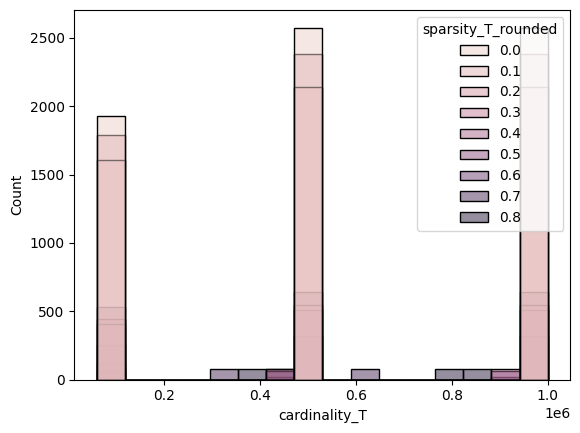

In [8]:
sigmod['sparsity_T_rounded'] = sigmod.sparsity_T.round(1)
sigmod['cardinality_T_rounded'] = sigmod.cardinality_T.divide(1000000).round(1)
sns.histplot(sigmod, x='cardinality_T', hue='sparsity_T_rounded')

<Axes: xlabel='sparsity_T', ylabel='Count'>

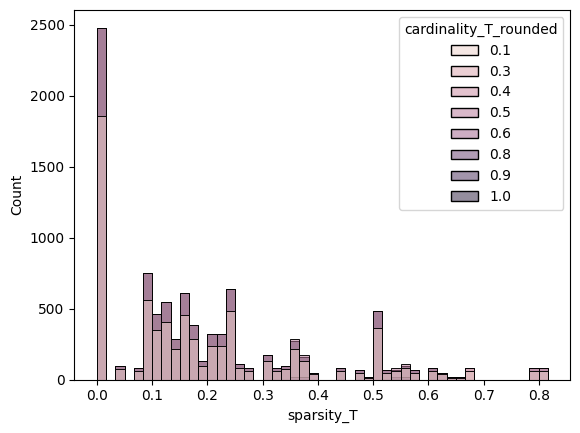

In [9]:
import seaborn as sns
sns.histplot(sigmod, x='sparsity_T', hue='cardinality_T_rounded')

In [10]:
hamlet[hamlet.morpheusfi_q != hamlet.morpheusfi_p]

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,mem_mat_read,mem_mat_write,...,r_T,c_T,sparsity_T,sparsity_S,morpheusfi_p,morpheusfi_q,morpheusfi_eis,morpheusfi_ns,morpheusfi_nis,label
48,expedia,1.238483,Linear Regression,32,1.051967,942142,991102,inner,1.303735,0.000038,...,942142,52282,0.999426,"[0.777777777777777, 0.999250811620744, 0.99962...",3,2,"[0.999250811620744, 0.9996272551066051]",942142,"[11939, 37021]",True
49,expedia,1.065269,Linear Regression,24,1.051967,942142,991102,inner,1.303735,0.000038,...,942142,52282,0.999426,"[0.777777777777777, 0.999250811620744, 0.99962...",3,2,"[0.999250811620744, 0.9996272551066051]",942142,"[11939, 37021]",True
50,expedia,0.734719,Linear Regression,16,1.051967,942142,991102,inner,1.303735,0.000038,...,942142,52282,0.999426,"[0.777777777777777, 0.999250811620744, 0.99962...",3,2,"[0.999250811620744, 0.9996272551066051]",942142,"[11939, 37021]",False
51,expedia,0.456479,Linear Regression,8,1.051967,942142,991102,inner,1.303735,0.000038,...,942142,52282,0.999426,"[0.777777777777777, 0.999250811620744, 0.99962...",3,2,"[0.999250811620744, 0.9996272551066051]",942142,"[11939, 37021]",False
52,expedia,1.256507,Gaussian,32,1.051967,942142,991102,inner,0.736818,0.000076,...,942142,52282,0.999426,"[0.777777777777777, 0.999250811620744, 0.99962...",3,2,"[0.999250811620744, 0.9996272551066051]",942142,"[11939, 37021]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,walmart,0.364473,KMeans,8,1.005657,421570,423955,left,0.274798,0.000140,...,421570,2441,0.994265,"[0.0, 0.9958106409719311, 0.943396226415094]",3,1,"[0.9958106409719311, 0.943396226415094]",421570,"[2340, 45]",False
284,walmart,0.699560,Logistic Regression,32,1.005657,421570,423955,left,0.158602,0.000016,...,421570,2441,0.994265,"[0.0, 0.9958106409719311, 0.943396226415094]",3,1,"[0.9958106409719311, 0.943396226415094]",421570,"[2340, 45]",False
285,walmart,0.556092,Logistic Regression,24,1.005657,421570,423955,left,0.158602,0.000016,...,421570,2441,0.994265,"[0.0, 0.9958106409719311, 0.943396226415094]",3,1,"[0.9958106409719311, 0.943396226415094]",421570,"[2340, 45]",False
286,walmart,0.304153,Logistic Regression,16,1.005657,421570,423955,left,0.158602,0.000016,...,421570,2441,0.994265,"[0.0, 0.9958106409719311, 0.943396226415094]",3,1,"[0.9958106409719311, 0.943396226415094]",421570,"[2340, 45]",False


In [11]:
model_features = ["operator", "num_cores",
                  # "r_T", "c_T", "r_S", "c_S", "Snonzero", "Tnonzero",
                  # "r_T", "c_T", 
                  "sparsity_T",
                  # "selectivity", 
                  "cardinality_T", "cardinality_S",
                  "fr", "tr", "comp_ratio",
        "mem_write_rowsum", "comp_lmm_fac", "comp_scalar_dense", "comp_lmm_mat"]
X = sigmod[model_features]

In [22]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import importlib
import matplotlib.pyplot as plt
from matplotlib.text import Text
import seaborn as sns

def train_and_score(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    categorical_features = ["operator"]
    if 'num_cores' in X.columns:
        categorical_features.append("num_cores")

    numeric_features = [x for x in X.columns if x not in categorical_features]

    transformers = [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ]

    preprocessor = ColumnTransformer(
        transformers=transformers
    )
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train, y_train)
    eval_model(pipe, X_test, y_test)
    return pipe

def eval_model(model, X_test, y_test, speedup=None):
    print(f"Model {model.__class__}")
    y_true = y_test
    y_pred = model.predict(X_test)
    
    scoring_functions = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "f1": f1_score
    }
    res = {}
    for name, function in scoring_functions.items():
        res[name] = function(y_true, y_pred)
        # print(f"Test {name} Score: {res[name]}")        
    fig = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='bone', text_kw={'size': 20})

    if speedup is not None:
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred)        
        
        best_speedup = speedup[speedup > 1.0].mean()
        speedup_dict = {}
        res['speedup'] = speedup_dict
        speedup_dict['tot_realized_speedup'] = speedup[y_pred].mean()
        speedup_dict['best_speedup'] = len(speedup), best_speedup
        speedup_dict['TP'] = len(speedup[y_pred & y_true]), speedup[y_pred & y_true].mean()
        speedup_dict['FP'] = len(speedup[y_pred & ~y_true]), speedup[y_pred & ~y_true].mean()
        speedup_dict['TN'] = len(speedup[y_pred & ~y_true]), speedup[~y_pred & ~y_true].mean()
        speedup_dict['FN'] = len(speedup[y_pred & ~y_true]), speedup[~y_pred & y_true].mean()
        
        cf = confusion_matrix(y_true, y_pred)
        
        group_counts = ['Counts: {0:0.0f}'.format(value) for value in
                        cf.flatten()]
        group_percentages = ['Percentages: {0:.2%}'.format(value) for value in
                             cf.flatten()/np.sum(cf)]
        group_spdup=['Avg speedups: {0:.2f}'.format(value) for value in [speedup_dict["TN"][1], speedup_dict["FP"][1], speedup_dict["FN"][1], speedup_dict["TP"][1], ]]
        group_names = ['True Negative','False Positive','False Negative','True Positive']
    
        labels = np.asarray([f'{v1}\n{v3}\n{v4}' for v1, v2, v3, v4 in
                  zip(group_names,group_counts,group_percentages, group_spdup)]).reshape(2,2)
        fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,4.2))
        
        sns.heatmap(cf, annot=labels,cmap='Blues',fmt='',ax=axes,cbar=True)
        axes.set_yticklabels(['Materialize','Factorize'],rotation=90)
        axes.set_xticklabels(['Materialize','Factorize'])
        axes.set_xlabel('Predicted label')
        axes.set_ylabel('True label')

        
#     res["model"] = model.__class__.__name__
    return res, fig


Model <class 'sklearn.pipeline.Pipeline'>


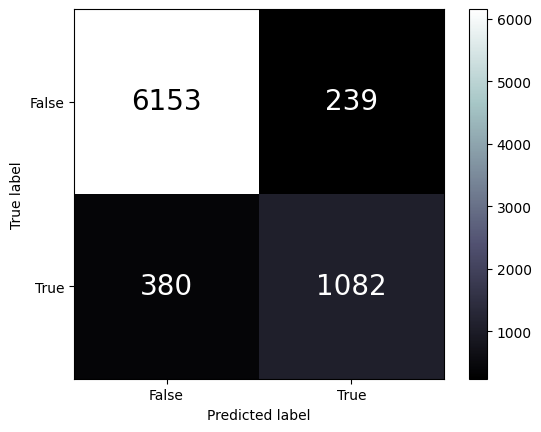

In [13]:
log_reg = train_and_score(LogisticRegression(max_iter=250), X, sigmod.label)

Model <class 'sklearn.pipeline.Pipeline'>


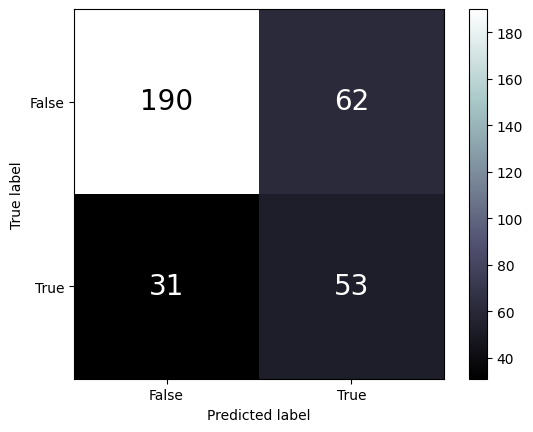

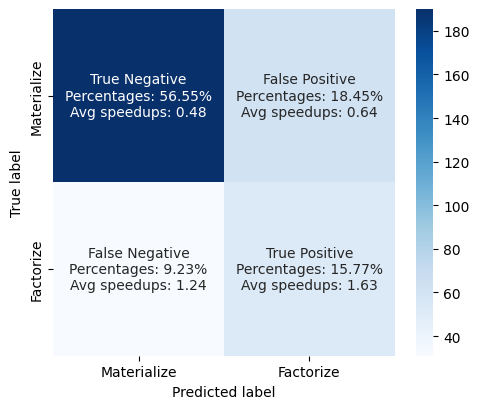

In [14]:
X_test = hamlet[model_features]
y_test = hamlet.label
_, fig = eval_model(log_reg, X_test, y_test, speedup=hamlet.speedup)
plt.tight_layout()
fig.savefig("logreg_confusion.pdf")

In [16]:
import math
from typing import Generator, List
from typing import Tuple
from abc import abstractmethod

class Classifier:
    _estimator_type = "classifier" # needed to make ConfusionMatrixDisplay work.

    def __init__(self, feature_list: List[str]):
        self.feature_list = feature_list

    def score(self, X, y):
        pred = self.predict(X)
        return np.count_nonzero((np.array(pred) != np.array(y))) / len(y)

    def predict(self, X):
        res = []
        for features in self.feature_iterator(X):
            res.append(self.optimize(*features))
        return res

    @abstractmethod
    def optimize(self, *args):
        ...

    def feature_iterator(self, X) -> Generator[Tuple, None, None]:
        yield from X[self.feature_list].values


class Morpheus(Classifier):
    tuple_ratio = 5
    feature_ratio = 1

    def __init__(self, tuple_ratio=5, feature_ratio=1):
        super().__init__(["tr", "fr"])
        self.tuple_ratio = tuple_ratio
        self.feature_ratio = feature_ratio

    def optimize(self, t, f):
        return t > self.tuple_ratio and f > self.feature_ratio

class Amalur(Classifier):

    def __init__(self, complexity_ratio=1.5):
        super().__init__(["comp_ratio"])
        self.complexity_ratio_boundary = complexity_ratio

    def optimize(self, c):
        return c > self.complexity_ratio_boundary

class MorpheusFI(Classifier):

    def __init__(self):
        # Number of base tables with sparsity < 5% q, number of base
        # tables p, sparsity of Ri ei, number of samples in S nS , number of rows in Ri ni.
        super().__init__(["morpheusfi_q", 'morpheusfi_p', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis'])

    def optimize(self, q: int, p: int, eis: List[float], ns: int, nis: List[int]):
        return q < math.floor(p/2) or (math.floor(q >= p/2) and all([ei * (ns / ni) > 1 for (ei, ni) in zip(eis, nis)]))

array([[Text(0, 0, '120'), Text(1, 0, '132')],
       [Text(0, 1, '24'), Text(1, 1, '60')]], dtype=object)

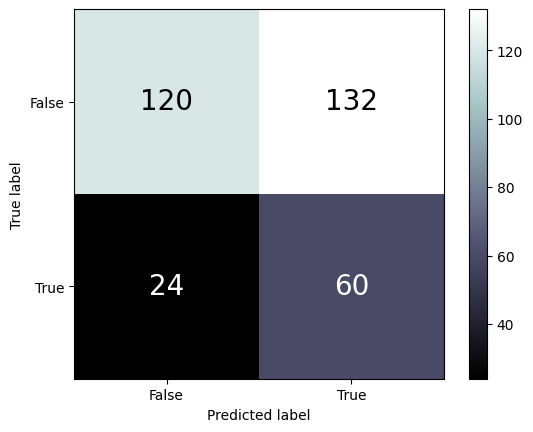

In [17]:
plt = ConfusionMatrixDisplay.from_estimator(Amalur(), X_test, y_test, cmap='bone', text_kw={'size': 20})
plt.text_

Model <class '__main__.MorpheusFI'>
Model <class '__main__.Morpheus'>
Model <class '__main__.Amalur'>
Model <class 'sklearn.pipeline.Pipeline'>


{'MorpheusFI': ({'accuracy': 0.39285714285714285,
   'precision': 0.2916666666666667,
   'recall': 1.0,
   'f1': 0.45161290322580644,
   'speedup': {'tot_realized_speedup': 1.4849913264438546,
    'best_speedup': (336, 1.4849913264438546),
    'TP': (84, 1.4849913264438546),
    'FP': (0, nan),
    'TN': (0, 0.5224104756998039),
    'FN': (0, nan)}},
  <Figure size 500x420 with 2 Axes>),
 'Morpheus': ({'accuracy': 0.4642857142857143,
   'precision': 0.16666666666666666,
   'recall': 0.2857142857142857,
   'f1': 0.2105263157894737,
   'speedup': {'tot_realized_speedup': 1.4849913264438546,
    'best_speedup': (336, 1.4849913264438546),
    'TP': (84, 1.4849913264438546),
    'FP': (0, nan),
    'TN': (0, 0.5224104756998039),
    'FN': (0, nan)}},
  <Figure size 500x420 with 2 Axes>),
 'Amalur': ({'accuracy': 0.5357142857142857,
   'precision': 0.3125,
   'recall': 0.7142857142857143,
   'f1': 0.43478260869565216,
   'speedup': {'tot_realized_speedup': 1.4849913264438546,
    'best_speed

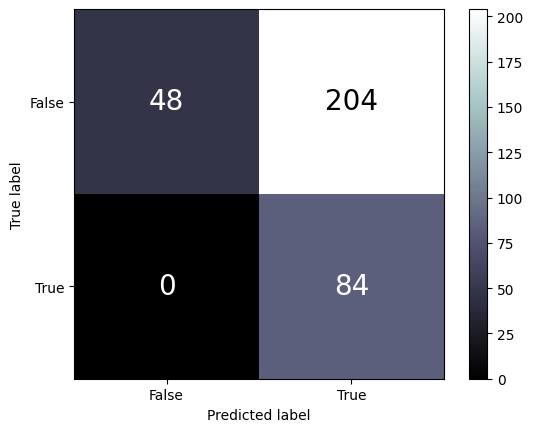

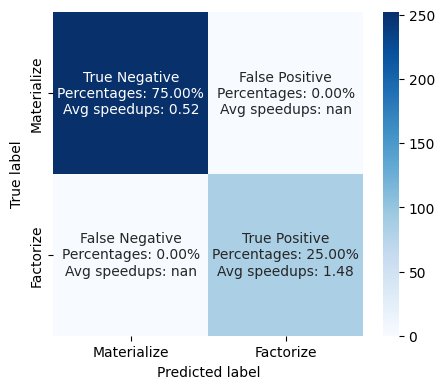

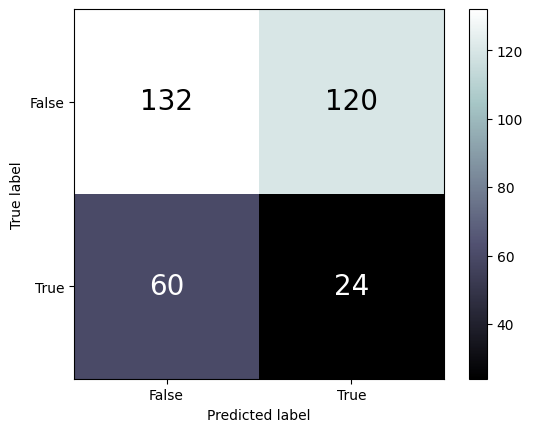

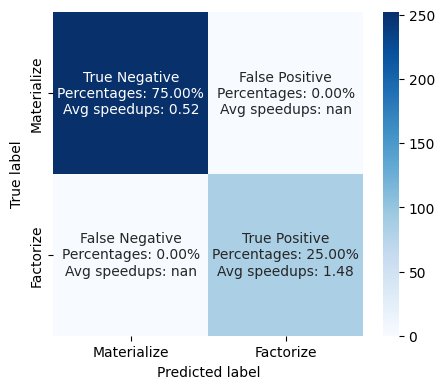

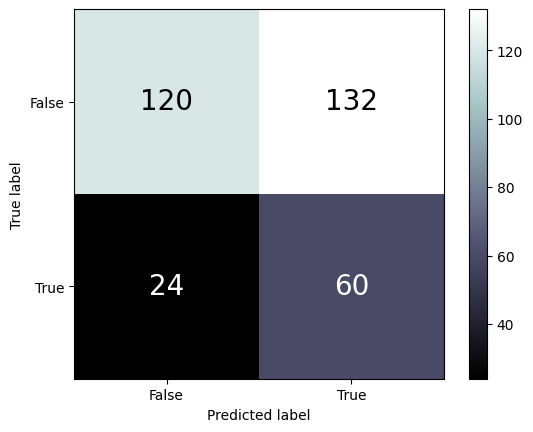

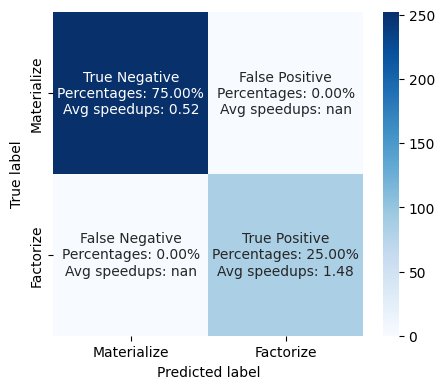

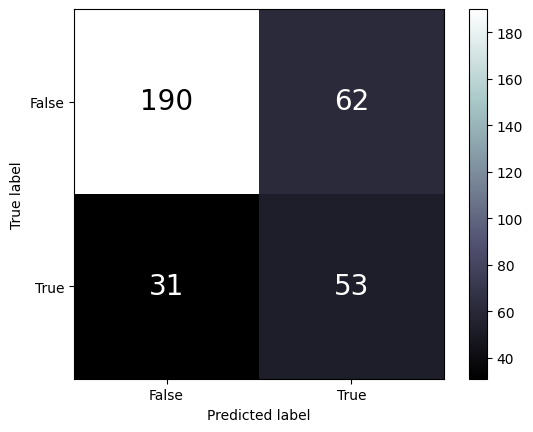

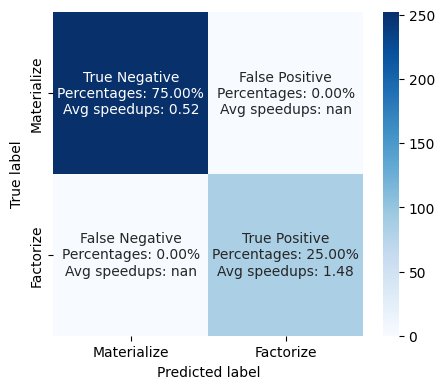

In [23]:
result_compare = {}

for model in [MorpheusFI(), Morpheus(), Amalur(), log_reg]:
    if isinstance(model, MorpheusFI):
        result_compare[model.__class__.__name__] = eval_model(model, hamlet[[x for x in hamlet.columns if 'morpheusfi' in x]], y_test, speedup=hamlet.speedup)
    else: 
        result_compare[model.__class__.__name__] = eval_model(model, X_test, y_test, speedup=hamlet.speedup)
result_compare

In [19]:
result_compare['Morpheus']

KeyError: 'Morpheus'

In [ ]:
compare_df = pd.DataFrame.from_dict(result_compare)
compare_df = compare_df[['Morpheus', 'MorpheusFI', 'Amalur', 'Pipeline']].style.format(precision=2)
compare_df

In [ ]:
print(compare_df.to_latex())

In [ ]:
eval_model(Amalur(), X_test, y_test)